# (공부) Datamining HW
> 두번째 과제, Classification
- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

In [12]:
setwd("/home/khy/Desktop/2022STAT/datamining")

library(tidyverse)
library(dplyr)
library(gridExtra)
library(ggplot2)
library(tidyr)
library(MASS) ## for lda
library(ROCR) ## for ROC
library(pastecs)
library(GGally)
library(class)

#### 1. 
**주식에 대한 배당금을 지급할지 여부(’Yes’, ’No’)를 예측하기 위해, 작년 한 해 동안의 수익률을 설명변수 X로 사용하고자 한다. 많은 수의 회사를 조사해보니 배당금을 지급한 회사의 주식 수익률의 평균 X¯=10 이고, 지급하지 않은 회사의 주식 수익률의 평균 X¯=0이다. 두 그룹에서 수익률의 분산은 두 그룹 모두 σˆ2=36이다. X가 정규분포를 따른다고 가정하자. 어떤 회사의 작년 수익률 X = 4였다면, 이 회사가 배당금을 지급할 확률은 얼마인가?**

In [648]:
f0=1/(6*sqrt(2*pi))*exp(-16/72)  #지급하지 않은 회사

In [649]:
f1=1/(6*sqrt(2*pi))*exp(-36/72)  #지급한 회사

In [647]:
p0=f0/(f0+f1)
p1=f1/(f0+f1)
print(p0)
print(p1)  #회사가 배당금을 지급할 확률

[1] 0.5690013
[1] 0.4309987


#### 2. 
**‘Auto.csv’ 데이터를 이용하여 자동차의 연비가 높을지 낮을지에 대해 예측을 하고자 한다. 다음 물음에 답하여라. (NA 처리 후 분석)**

- mpg : miles per gallon
- cylinders : Number of cylinders between 4 and 8
- displacement : Engine displacement (cu. inches)
- horsepower : Engine horsepower
- weight : Vehicle weight (lbs.)
- acceleration : Time to accelerate from 0 to 60 mph (sec.)
- year: Model year (modulo 100)
- origin : Origin of car (1. American, 2. European, 3. Japanese)
- name : Vehicle name

##### (a) 
mpg01 변수를 생성하여라. 이 변수는 mpg가 mpg의 중앙값보다 크면 1의 값을 갖고 아니면 0의 값을 갖는 변수이다. (중앙값 : median())

In [112]:
dt=read.csv("Auto(3).csv")
dt$horsepower=as.numeric(dt$horsepower)
dt = dt %>% filter(horsepower!="NA")

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [113]:
dt$mpg01 <- ifelse(dt$mpg>median(dt$mpg),1.0, 0.0)

##### (b) 
시각화를 통하여 mpg01과 다른 변수들 사이의 관계를 확인하고 설명하여라. 어떤 변수가 mp01을 예측하는 데 가장 유용할 것으로 생각되는가?

- 그림을 확인한 결과, mpg01 값에 따라 완벽히 분리되는 경우는 없어보인다.
- 가장 분리가 잘된 것 처럼 보이는 `horsepower*weight`, `horsepower*acceleration` 변수가 mpg01을 예측하는데 가장 유용할 것으로 생각된다.

In [132]:
dt$mpg_chr<-as.character(dt$mpg01)

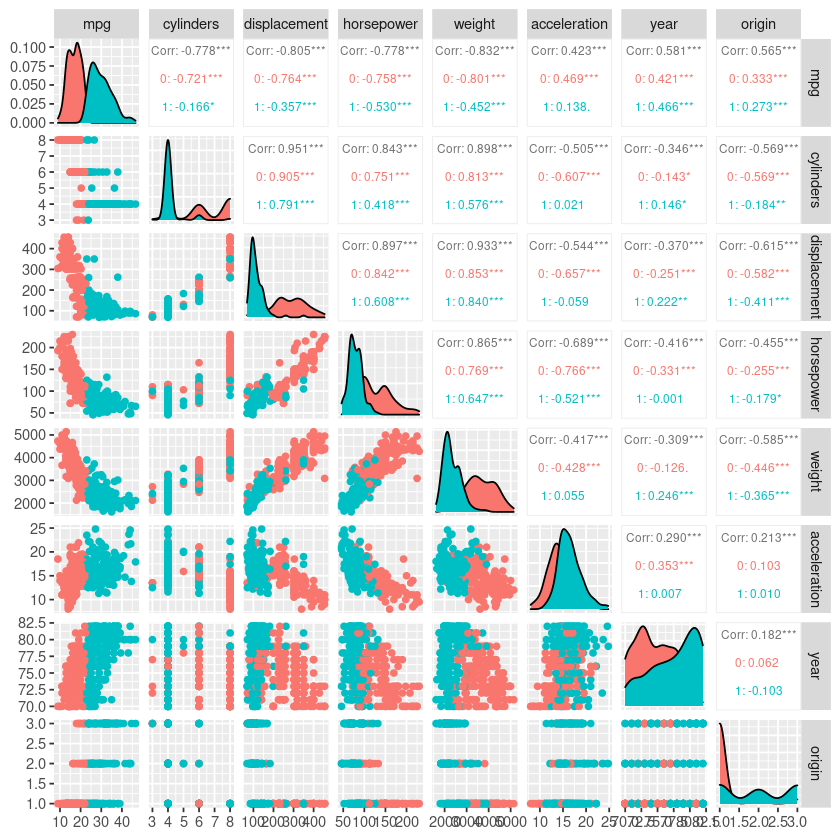

In [650]:
ggpairs(dt[,1:8], mapping=aes(color=dt$mpg_chr), upper = list(continuous = wrap("cor", size = 2.5), lower = list(continuous = wrap("points",size=0.001))))

##### (c)
데이터를 training data (60%)와 testing data(40%)로 나누어라.

In [291]:
set.seed(1234)

In [292]:
train_id <- sample(1:nrow(dt), nrow(dt)*0.6)
train_dt <- dt[train_id,]
test_dt <- dt[-train_id,]

##### (d) 
(b)에서 연관이 있다고 생각되는 변수들을 이용하여, mpg01을 예측하기 위한 LDA를 수행하여라. test 오분류율은 얼마인가?

In [293]:
stat.desc(dt %>% filter(mpg01==0))[12,2:7]
stat.desc(dt %>% filter(mpg01==1))[12,2:7]

,cylinders,displacement,horsepower,weight,acceleration,year
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
var,2.016431,8014.544,1395.444,458237.2,7.210051,8.825432


,cylinders,displacement,horsepower,weight,acceleration,year
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
var,0.4551282,1476.827,253.4364,157761.8,6.215888,13.35521


In [296]:
lda.fit1 <- lda(mpg01 ~ horsepower+weight, data = train_dt)
lda.fit2 <- lda(mpg01 ~ horsepower+acceleration, data = train_dt)
lda.fit3 <- lda(mpg01 ~ horsepower+year, data = train_dt)

In [297]:
mean(train_dt$mpg01 != predict(lda.fit1)$class) ## 오분류율
mean(train_dt$mpg01 != predict(lda.fit2)$class) ## 오분류율
mean(train_dt$mpg01 != predict(lda.fit3)$class) ## 오분류율

[1] 0.106383

[1] 0.1361702

[1] 0.1489362

In [298]:
lda.fit1 <- lda(mpg01 ~ horsepower+weight, data = test_dt)
lda.fit2 <- lda(mpg01 ~ horsepower+acceleration, data = test_dt)
lda.fit3 <- lda(mpg01 ~ horsepower+year, data = test_dt)

In [299]:
mean(test_dt$mpg01 != predict(lda.fit1)$class) ## 오분류율
mean(test_dt$mpg01 != predict(lda.fit2)$class) ## 오분류율
mean(test_dt$mpg01 != predict(lda.fit3)$class) ## 오분류율

[1] 0.133758

[1] 0.1719745

[1] 0.1847134

- `horsepower*weight`에서 테스트 오분류율이 적게 나타났다. 

##### (e) 
(b)에서 연관이 있다고 생각되는 변수들을 이용하여, mpg01을 예측하기 위한 QDA를 수행하여라. test 오분류율은 얼마인가?

In [300]:
qda.fit1 <- qda(mpg01 ~ horsepower+weight, data = train_dt)
qda.fit2 <- qda(mpg01 ~ horsepower+acceleration, data = train_dt)

In [301]:
mean(train_dt$mpg01 != predict(qda.fit1)$class) ## 오분류율
mean(train_dt$mpg01 != predict(qda.fit2)$class) ## 오분류율

[1] 0.106383

[1] 0.1319149

In [302]:
qda.fit1 <- qda(mpg01 ~ horsepower+weight, data = test_dt)
qda.fit2 <- qda(mpg01 ~ horsepower+acceleration, data = test_dt)

In [303]:
mean(test_dt$mpg01 != predict(qda.fit1)$class) ## 오분류율
mean(test_dt$mpg01 != predict(qda.fit2)$class) ## 오분류율

[1] 0.1528662

[1] 0.1719745

##### (f) 
(b)에서 연관이 있다고 생각되는 변수들을 이용하여, mpg01을 예측하기 위한 logistic regression을 수행하여라. test 오분류율은 얼마인가?

In [651]:
glm.fits <- glm(mpg01 ~ cylinders + displacement + horsepower + weight + acceleration + year, data = train_dt, family = binomial)
summary(glm.fits)


Call:
glm(formula = mpg01 ~ cylinders + displacement + horsepower + 
    weight + acceleration + year, family = binomial, data = train_dt)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.13040  -0.06976   0.02981   0.20439   2.56308  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -20.695360   7.957351  -2.601 0.009301 ** 
cylinders     -0.552688   0.582712  -0.948 0.342888    
displacement   0.017868   0.013743   1.300 0.193535    
horsepower    -0.036273   0.029523  -1.229 0.219209    
weight        -0.005340   0.001569  -3.403 0.000668 ***
acceleration  -0.002061   0.174576  -0.012 0.990583    
year           0.519138   0.117550   4.416    1e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 324.548  on 234  degrees of freedom
Residual deviance:  85.927  on 228  degrees of freedom
AIC: 99.927

Number of Fisher Scoring

In [652]:
glm.fits1 <- glm(mpg01 ~ horsepower + weight, data = test_dt, family = binomial)
summary(glm.fits1)


Call:
glm(formula = mpg01 ~ horsepower + weight, family = binomial, 
    data = test_dt)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.21066  -0.36105  -0.01395   0.30824   2.05887  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) 14.7491888  2.6517392   5.562 2.67e-08 ***
horsepower  -0.0391169  0.0209543  -1.867   0.0619 .  
weight      -0.0039785  0.0008208  -4.847 1.25e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 215.804  on 156  degrees of freedom
Residual deviance:  87.543  on 154  degrees of freedom
AIC: 93.543

Number of Fisher Scoring iterations: 7


In [216]:
glm.fits2 <- glm(mpg01 ~ horsepower + acceleration, data = test_dt, family = binomial)
summary(glm.fits2)


Call:
glm(formula = mpg01 ~ horsepower + acceleration, family = binomial, 
    data = test_dt)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.22969  -0.31280  -0.00056   0.47233   2.18530  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   24.3847     4.9472   4.929 8.26e-07 ***
horsepower    -0.1501     0.0268  -5.599 2.15e-08 ***
acceleration  -0.6282     0.1698  -3.700 0.000215 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 217.591  on 156  degrees of freedom
Residual deviance:  95.793  on 154  degrees of freedom
AIC: 101.79

Number of Fisher Scoring iterations: 7


In [282]:
glm.fits3 <- glm(mpg01 ~ horsepower + year, data = test_dt, family = binomial)
summary(glm.fits3)


Call:
glm(formula = mpg01 ~ horsepower + year, family = binomial, data = test_dt)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.03181  -0.45061  -0.00297   0.45333   2.06993  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -8.90702    5.77087  -1.543  0.12272    
horsepower  -0.09160    0.01670  -5.484 4.16e-08 ***
year         0.23241    0.07618   3.051  0.00228 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 217.59  on 156  degrees of freedom
Residual deviance: 104.63  on 154  degrees of freedom
AIC: 110.63

Number of Fisher Scoring iterations: 6


In [655]:
reg_test_dt <- test_dt

In [656]:
reg_test_dt$fitted_class1 <- ifelse(predict(glm.fits1, type='response')>0.5,1,0)
reg_test_dt$fitted_class2 <- ifelse(predict(glm.fits2, type='response')>0.5,1,0)
reg_test_dt$fitted_class3 <- ifelse(predict(glm.fits3, type='response')>0.5,1,0)

In [657]:
head(reg_test_dt)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01,mpg_chr,fitted_class1,fitted_class2,fitted_class3
,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu,0,0,0,0,0
2,15,8,350,165,3693,11.5,70,1,buick skylark 320,0,0,0,0,0
3,18,8,318,150,3436,11.0,70,1,plymouth satellite,0,0,0,0,0
5,17,8,302,140,3449,10.5,70,1,ford torino,0,0,0,0,0
8,14,8,440,215,4312,8.5,70,1,plymouth fury iii,0,0,0,0,0
9,14,8,455,225,4425,10.0,70,1,pontiac catalina,0,0,0,0,0


In [658]:
mean(reg_test_dt$fitted_class1!=test_dt$mpg01)
mean(reg_test_dt$fitted_class2!=test_dt$mpg01)
mean(reg_test_dt$fitted_class3!=test_dt$mpg01)

[1] 0.1210191

[1] 0.1528662

[1] 0.4012739

##### (g) 
(b)에서 연관이 있다고 생각되는 변수들을 이용하여, mpg01을 예측하기 위한 KNN을 수행
하여라. KNN을 수행할 때 몇개의 k 값을 선택하여 분석하여라. test 오분류율은 얼마인가?
어떤 k를 선택했을 때 결과가 가장 좋았는가?

In [540]:
head(test_dt)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01,mpg_chr
,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>
1,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu,0,0
2,15,8,350,165,3693,11.5,70,1,buick skylark 320,0,0
3,18,8,318,150,3436,11.0,70,1,plymouth satellite,0,0
5,17,8,302,140,3449,10.5,70,1,ford torino,0,0
8,14,8,440,215,4312,8.5,70,1,plymouth fury iii,0,0
9,14,8,455,225,4425,10.0,70,1,pontiac catalina,0,0


In [541]:
set.seed(1234)
train_dt_x<-train_dt[,4:5]
train_dt_y<-train_dt[,10]

In [542]:
set.seed(1234)
test_dt_x<-test_dt[,4:5]
test_dt_y<-test_dt[,10]

In [543]:
pred_test <- knn(train_dt_x, test_dt_x, 
                 cl=train_dt_y, k=1, prob = T)  #k=1 가장 복잡할 때
mean(pred_test!=test_dt_y)  # 오분류율

[1] 0.1656051

In [544]:
pred_test <- knn(train_dt_x, test_dt_x, 
                 cl=train_dt_y, k=11, prob = T)  #k=1 가장 복잡할 때
mean(pred_test!=test_dt_y)  # 오분류율

[1] 0.1528662

In [545]:
pred_test <- knn(train_dt_x, test_dt_x, 
                 cl=train_dt_y, k=12, prob = T)  #k=1 가장 복잡할 때
mean(pred_test!=test_dt_y)  # 오분류율

[1] 0.1464968

In [546]:
pred_test <- knn(train_dt_x, test_dt_x, 
                 cl=train_dt_y, k=13, prob = T)  #k=1 가장 복잡할 때
mean(pred_test!=test_dt_y)  # 오분류율

[1] 0.1273885

In [549]:
pred_test <- knn(train_dt_x, test_dt_x, 
                 cl=train_dt_y, k=14, prob = T)  #k=1 가장 복잡할 때
mean(pred_test!=test_dt_y)  # 오분류율

[1] 0.1401274

In [550]:
pred_test <- knn(train_dt_x, test_dt_x, 
                 cl=train_dt_y, k=15, prob = T)  #k=1 가장 복잡할 때
mean(pred_test!=test_dt_y)  # 오분류율

[1] 0.1401274

In [547]:
k.grid <- seq(1,19,1)  #k=1~21 중에 찾기, 이 때 홀수로 해주는 것이 좋음
acc_df <- data.frame(k = k.grid, acc = NA)

for(i in 1:length(k.grid)){
    pred_test <- knn(train_dt_x, test_dt_x, 
                   cl=train_dt_y, k=k.grid[i])  ## test data 예측 
    acc_df[i,2] <- mean(pred_test!=test_dt_y)} # 오분류율

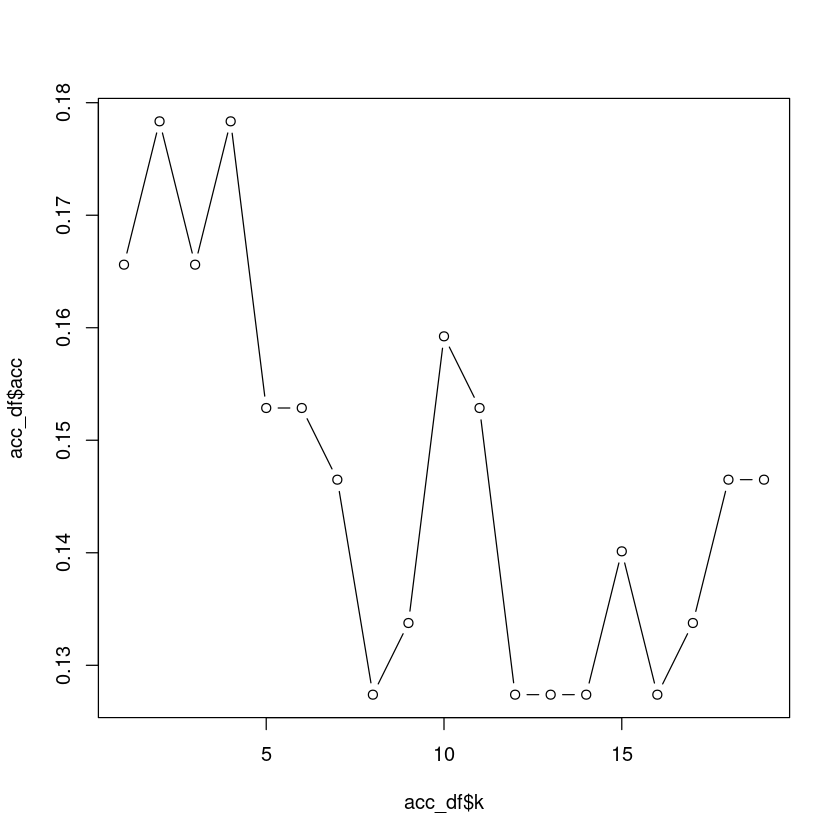

In [551]:
plot(acc_df$k, acc_df$acc, type='b')

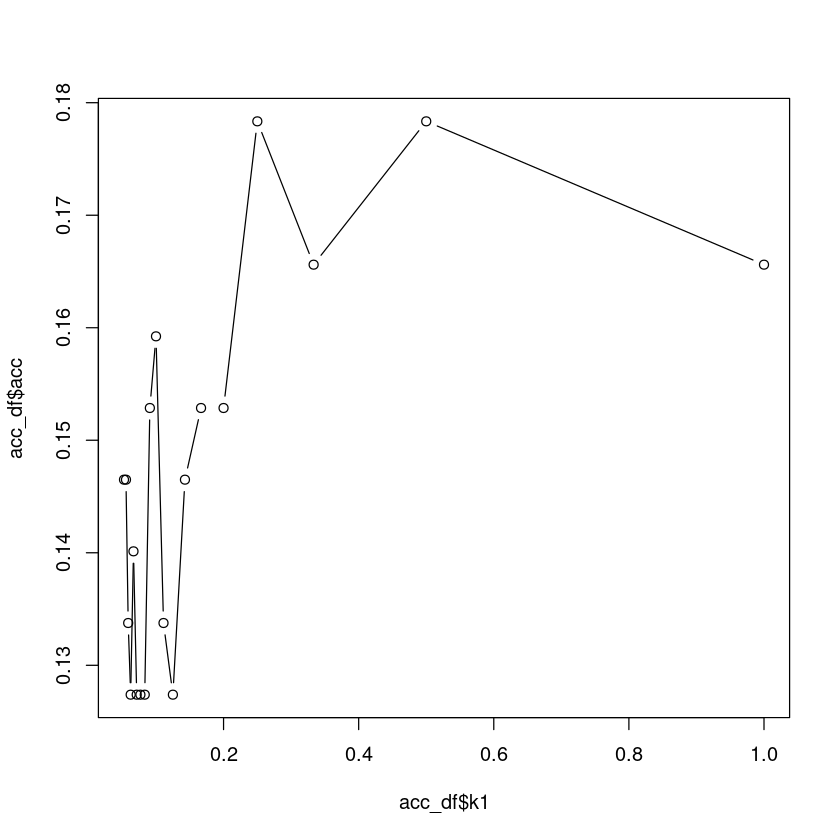

In [552]:
acc_df$k1 <- 1/acc_df$k
plot(acc_df$k1, acc_df$acc, type='b')

##### (*) ROC 커브

In [567]:
lda.fit <- lda(mpg01 ~ horsepower+weight, data = test_dt)
lda.pred <- predict(lda.fit1)

In [568]:
##### ROC
pred_ROCR <- prediction(lda.pred$posterior[,2], test_dt$mpg01)  
roc_ROCR <- performance(pred_ROCR, measure = "tpr", x.measure = "fpr")

In [569]:
qda.fit <- qda(mpg01 ~ horsepower+weight, data = test_dt)
qda.pred <- predict(qda.fit)

In [571]:
##### ROC
pred_ROCR_qda <- prediction(qda.pred$posterior[,2], test_dt$mpg01)  
roc_ROCR_qda <- performance(pred_ROCR, measure = "tpr", x.measure = "fpr")

In [566]:
### logistic
glm.fits <- glm(mpg01 ~ horsepower + weight, data = test_dt, family = binomial)
#summary(glm.fits)
pred_ROCR_logsitc <- prediction(predict(glm.fits, type='response'), test_dt$mpg01)
roc_ROCR_logsitc <- performance(pred_ROCR_logsitc, measure = "tpr", x.measure = "fpr")

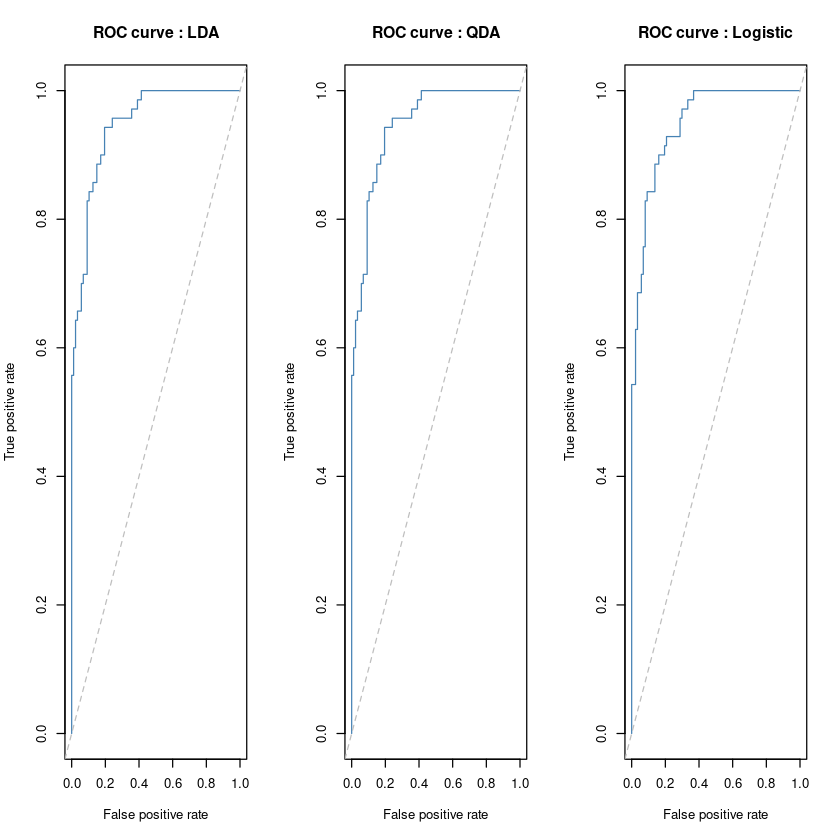

In [572]:
par(mfrow=c(1,3))
plot(roc_ROCR, main = "ROC curve : LDA", col='steelblue')
abline(a = 0, b = 1, lty=2, col='grey')

plot(roc_ROCR_qda, main = "ROC curve : QDA", col='steelblue')
abline(a = 0, b = 1, lty=2, col='grey')

plot(roc_ROCR_logsitc, main = "ROC curve : Logistic", col='steelblue')
abline(a = 0, b = 1, lty=2, col='grey')

In [575]:
##### AUC
auc_ROCR <- performance(pred_ROCR, measure = "auc")
auc_ROCR@y.values[[1]]

auc_ROCR_qda <- performance(pred_ROCR_qda, measure = "auc")
auc_ROCR_qda@y.values[[1]]

auc_ROCR_logsitc <- performance(pred_ROCR_logsitc, measure = "auc")
auc_ROCR_logsitc@y.values[[1]]  #이게 가장 좋음

[1] 0.9456486

[1] 0.9336617

[1] 0.9479475

#### 3. 
**‘Boston.csv’ 데이터를 이용하여, 어떤 지역의 범죄율이 중앙값 이상인지 아닌지를 예측하기 위한
분류 모형(logistic regression, LDA, KNN)을 적합하여라.**

In [13]:
bstn=read.csv("Boston(1).csv")

In [14]:
nrow(bstn) 
head(bstn)

[1] 506

,X,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
6,6,0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7


In [15]:
bstn$crim1 <- ifelse(bstn$crim>=median(bstn$crim),1, 0)
bstn$crim100 <- bstn$crim*100
head(bstn)

,X,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,crim1,crim100
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0,0.632
2,2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,0,2.731
3,3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,0,2.729
4,4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,0,3.237
5,5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,0,6.905
6,6,0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7,0,2.985


##### 변수
- crim : 도시별 1인당 범죄율
- zn : 25,000평방피트 이상의 부지로 구획된 주거용 토지의 비율
- indus : 도시당 비소매업 에이커의 비율
- chas : Charles River 더미 변수(= tract bounds river이면 1, 그렇지 않으면 0)
- nox : 질소산화물 농도(parts per 10 million)
- rm : 가구당 평균 방 수
- age : 1940년 이전에 지어진 소유주가 차지하는 비율
- dis : 5개의 보스턴 고용 센터까지의 거리의 가중 평균
- rad : 방사형 고속도로 접근성 지수
- tax : 10,000달러당 전체 가치 재산세율
- ptratio : 도시별 학생-교사 비율
- lstat : 지위가 낮은 인구(낮은 신분, 좋지 않은 직업) 퍼센트
- medv : $1000s의 소유자가 거주하는 주택의 중앙값

- 완벽하게 분리되는 변수는 없으나, 비교적 분리가 되는 변수인 `nox`, `dis` 조합을 선택한다.

In [16]:
bstn$crim_chr<-as.character(bstn$crim1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



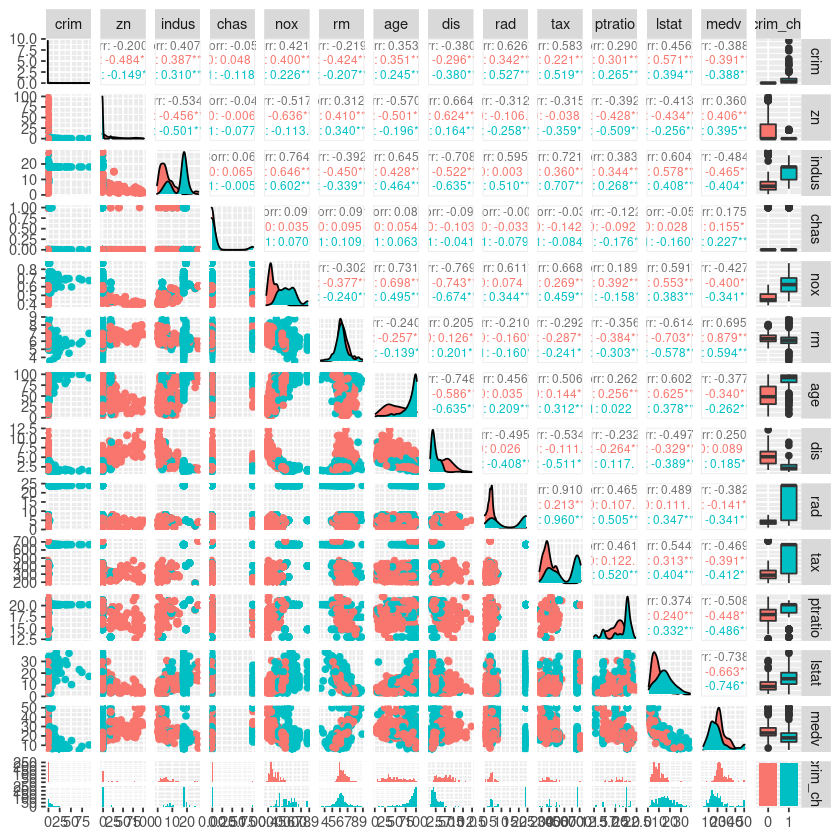

In [17]:
ggpairs(bstn[,c(2:14,17)], mapping=aes(color=bstn$crim_chr), upper = list(continuous = wrap("cor", size = 2.5), lower = list(continuous = wrap("points",size=0.001))))

In [18]:
set.seed(1234)
train_id <- sample(1:nrow(bstn), nrow(bstn)*0.6)
train_bstn <- bstn[train_id,]
test_bstn <- bstn[-train_id,]

In [19]:
nrow(train_bstn)
nrow(test_bstn)
nrow(bstn)

[1] 303

[1] 203

[1] 506

##### (1) LDA

In [20]:
stat.desc(bstn %>% filter(crim1==0))[12,2:14]
stat.desc(bstn %>% filter(crim1==1))[12,2:14]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
var,0.003946068,859.6511,30.4092,0.04893657,0.003091125,0.3087865,669.8727,4.331826,2.752682,7653.398,3.280505,24.24082,52.30251


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
var,123.4126,23.02666,29.58283,0.07971014,0.009742411,0.6563237,319.4883,1.178355,90.8179,28175.4,5.508159,56.95603,105.4803


In [21]:
lda.fit1 <- lda(crim1 ~ nox + ptratio, data = train_bstn)
lda.fit2 <- lda(crim1 ~ nox + rad, data = train_bstn)
lda.fit3 <- lda(crim1 ~ rad + lstat, data = train_bstn)
lda.fit4 <- lda(crim1 ~ nox + lstat, data = train_bstn)

In [22]:
mean(train_bstn$crim1 != predict(lda.fit1)$class) ## 오분류율
mean(train_bstn$crim1 != predict(lda.fit2)$class) ## 오분류율
mean(train_bstn$crim1 != predict(lda.fit3)$class) ## 오분류율
mean(train_bstn$crim1 != predict(lda.fit4)$class) ## 오분류율

[1] 0.1650165

[1] 0.1221122

[1] 0.2112211

[1] 0.1650165

In [23]:
lda.fit1 <- lda(crim1 ~ nox + ptratio, data = test_bstn)
lda.fit2 <- lda(crim1 ~ nox + rad, data = test_bstn)
lda.fit3 <- lda(crim1 ~ rad + lstat, data = test_bstn)
lda.fit4 <- lda(crim1 ~ nox + lstat, data = test_bstn)

In [24]:
mean(test_bstn$crim1 != predict(lda.fit1)$class) ## 오분류율
mean(test_bstn$crim1 != predict(lda.fit2)$class) ## 오분류율
mean(test_bstn$crim1 != predict(lda.fit3)$class) ## 오분류율
mean(test_bstn$crim1 != predict(lda.fit4)$class) ## 오분류율

[1] 0.1280788

[1] 0.1625616

[1] 0.2413793

[1] 0.2118227

In [28]:
##### ROC
lda.pred1 <- predict(lda.fit1)
lda.pred2 <- predict(lda.fit2)

pred_ROCR1 <- prediction(lda.pred1$posterior[,2], test_bstn$crim1)  
roc_ROCR1 <- performance(pred_ROCR1, measure = "tpr", x.measure = "fpr")
pred_ROCR2 <- prediction(lda.pred2$posterior[,2], test_bstn$crim1) 
roc_ROCR2 <- performance(pred_ROCR2, measure = "tpr", x.measure = "fpr")

In [29]:
##### AUC
auc_ROCR1 <- performance(pred_ROCR1, measure = "auc")
auc_ROCR1@y.values[[1]]
auc_ROCR2 <- performance(pred_ROCR2, measure = "auc")
auc_ROCR2@y.values[[1]]

[1] 0.9443797

[1] 0.9464182

##### (2) logistic regression

- 전체 변수로 로지스틱 회귀분석을 실행한 결과, 상수항과 `nox`, `rad`이 유의한 변수로 확인되었다.

In [30]:
glm.fits <- glm(crim1 ~ zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + lstat + medv, data = train_bstn, family = binomial)
summary(glm.fits)


Call:
glm(formula = crim1 ~ zn + indus + chas + nox + rm + age + dis + 
    rad + tax + ptratio + lstat + medv, family = binomial, data = train_bstn)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.32155  -0.13237   0.00000   0.00046   2.18827  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -47.409683   9.293314  -5.101 3.37e-07 ***
zn           -0.147618   0.057951  -2.547 0.010856 *  
indus        -0.068620   0.061664  -1.113 0.265795    
chas          1.646071   1.080132   1.524 0.127520    
nox          59.515644  11.185326   5.321 1.03e-07 ***
rm           -0.174264   1.003234  -0.174 0.862099    
age           0.019297   0.017393   1.109 0.267235    
dis           1.023295   0.334159   3.062 0.002196 ** 
rad           0.792594   0.224255   3.534 0.000409 ***
tax          -0.005893   0.003402  -1.732 0.083249 .  
ptratio       0.243794   0.166163   1.467 0.142321    
lstat         0.109783   0.072017   1.524 0.127407

In [31]:
glm.fits <- glm(crim1 ~ zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + lstat + medv, data = test_bstn, family = binomial)
summary(glm.fits)


Call:
glm(formula = crim1 ~ zn + indus + chas + nox + rm + age + dis + 
    rad + tax + ptratio + lstat + medv, family = binomial, data = test_bstn)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.11401  -0.21387  -0.00862   0.01368   2.86368  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -33.243535   8.419402  -3.948 7.87e-05 ***
zn           -0.021454   0.038303  -0.560 0.575401    
indus        -0.036419   0.067549  -0.539 0.589786    
chas         -0.389238   1.070174  -0.364 0.716071    
nox          37.413640  10.901576   3.432 0.000599 ***
rm           -0.572734   1.063417  -0.539 0.590177    
age           0.028733   0.019140   1.501 0.133303    
dis           0.350235   0.282855   1.238 0.215638    
rad           0.570402   0.237046   2.406 0.016115 *  
tax          -0.005203   0.005255  -0.990 0.322088    
ptratio       0.499273   0.189982   2.628 0.008589 ** 
lstat         0.009967   0.074652   0.134 0.893792 

In [32]:
glm.fits1 <- glm(crim1 ~ nox + rad, data = test_bstn, family = binomial)
summary(glm.fits1)


Call:
glm(formula = crim1 ~ nox + rad, family = binomial, data = test_bstn)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.15087  -0.35733  -0.06901   0.01476   2.43086  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -17.7607     2.9967  -5.927 3.09e-09 ***
nox          29.3855     5.2036   5.647 1.63e-08 ***
rad           0.4083     0.1525   2.678  0.00741 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 281.41  on 202  degrees of freedom
Residual deviance: 115.59  on 200  degrees of freedom
AIC: 121.59

Number of Fisher Scoring iterations: 8


In [33]:
reg_test_bstn <- test_bstn

In [34]:
reg_test_bstn$fitted_class1 <- ifelse(predict(glm.fits1, type='response')>0.5,1,0)

In [35]:
head(reg_test_bstn)

,X,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,crim1,crim100,crim_chr,fitted_class1
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0,0.632,0,0
3,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,0,2.729,0,0
5,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,0,6.905,0,0
7,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,12.43,22.9,0,8.829,0,0
8,8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,19.15,27.1,0,14.455,0,0
9,9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,29.93,16.5,0,21.124,0,0


In [36]:
mean(reg_test_bstn$fitted_class1!=test_bstn$crim1)

[1] 0.1674877

##### (3) KNN

In [37]:
set.seed(1234)
train_bstn_x<-train_bstn[,c(6,10)]
train_bstn_y<-train_bstn[,15]

In [38]:
test_bstn_x<-test_bstn[,c(6,10)]
test_bstn_y<-test_bstn[,15]

In [39]:
pred_test <- knn(train_bstn_x, test_bstn_x, 
                 cl=train_bstn_y, k=1, prob = T)  #k=1 가장 복잡할 때
mean(pred_test!=test_bstn_y)  # 오분류율

[1] 0.06896552

In [40]:
pred_test <- knn(train_bstn_x, test_bstn_x, 
                 cl=train_bstn_y, k=3, prob = T)  
mean(pred_test!=test_bstn_y)  # 오분류율

pred_test <- knn(train_bstn_x, test_bstn_x, 
                 cl=train_bstn_y, k=4, prob = T)  
mean(pred_test!=test_bstn_y)  # 오분류율

pred_test <- knn(train_bstn_x, test_bstn_x, 
                 cl=train_bstn_y, k=5, prob = T)  
mean(pred_test!=test_bstn_y)  # 오분류율

pred_test <- knn(train_bstn_x, test_bstn_x, 
                 cl=train_bstn_y, k=6, prob = T)  
mean(pred_test!=test_bstn_y)  # 오분류율

pred_test <- knn(train_bstn_x, test_bstn_x, 
                 cl=train_bstn_y, k=7, prob = T)  
mean(pred_test!=test_bstn_y)  # 오분류율

pred_test <- knn(train_bstn_x, test_bstn_x, 
                 cl=train_bstn_y, k=8, prob = T)  
mean(pred_test!=test_bstn_y)  # 오분류율

[1] 0.04926108

[1] 0.04926108

[1] 0.05418719

[1] 0.0591133

[1] 0.0591133

[1] 0.05418719

In [41]:
nrow(train_bstn)

[1] 303

In [42]:
set.seed(1234)
k.grid <- seq(1,25,1)  #k=1~21 중에 찾기, 이 때 홀수로 해주는 것이 좋음
acc_df <- data.frame(k = k.grid, acc = NA)

for(i in 1:length(k.grid)){
    pred_test <- knn(train_bstn_x, test_bstn_x, 
                   cl=train_bstn_y, k=k.grid[i])  ## test data 예측 
    acc_df[i,2] <- mean(pred_test!=test_bstn_y)} # 오분류율

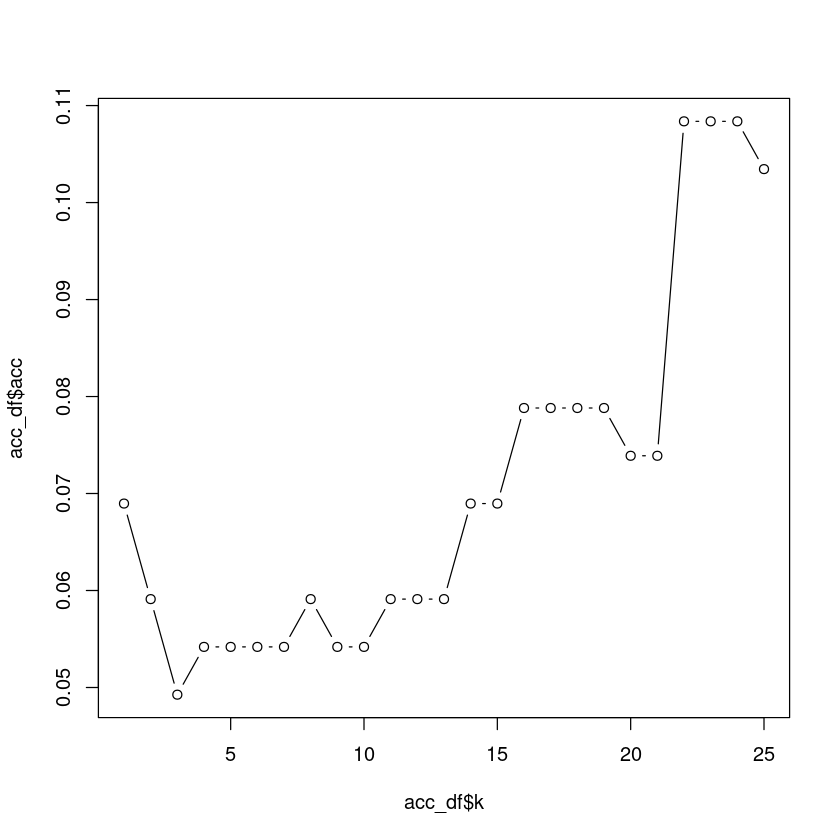

In [43]:
plot(acc_df$k, acc_df$acc, type='b')

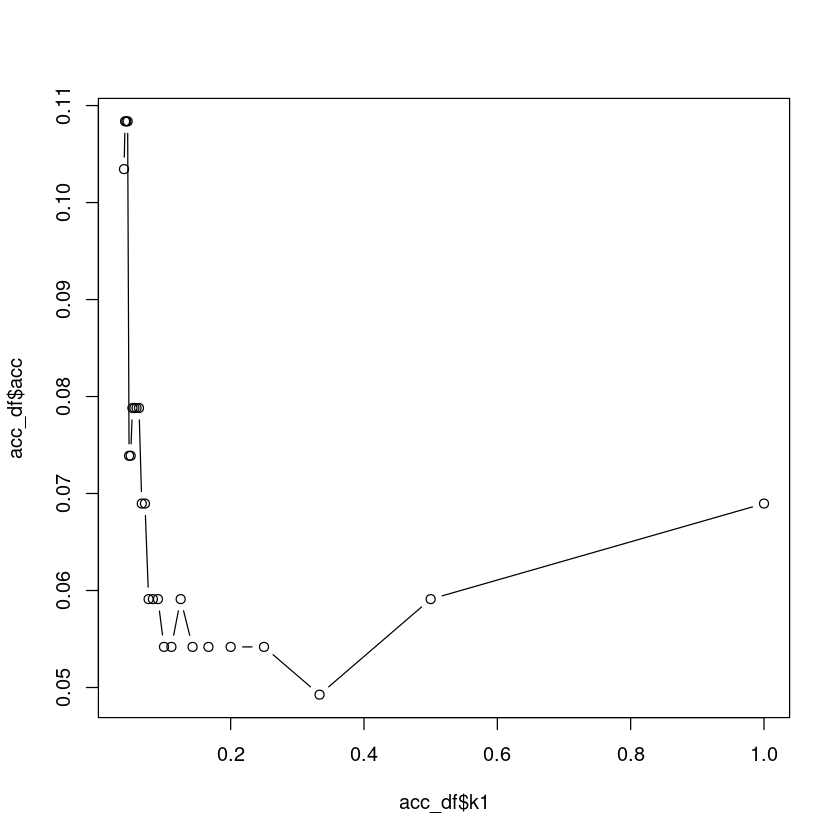

In [44]:
acc_df$k1 <- 1/acc_df$k
plot(acc_df$k1, acc_df$acc, type='b')

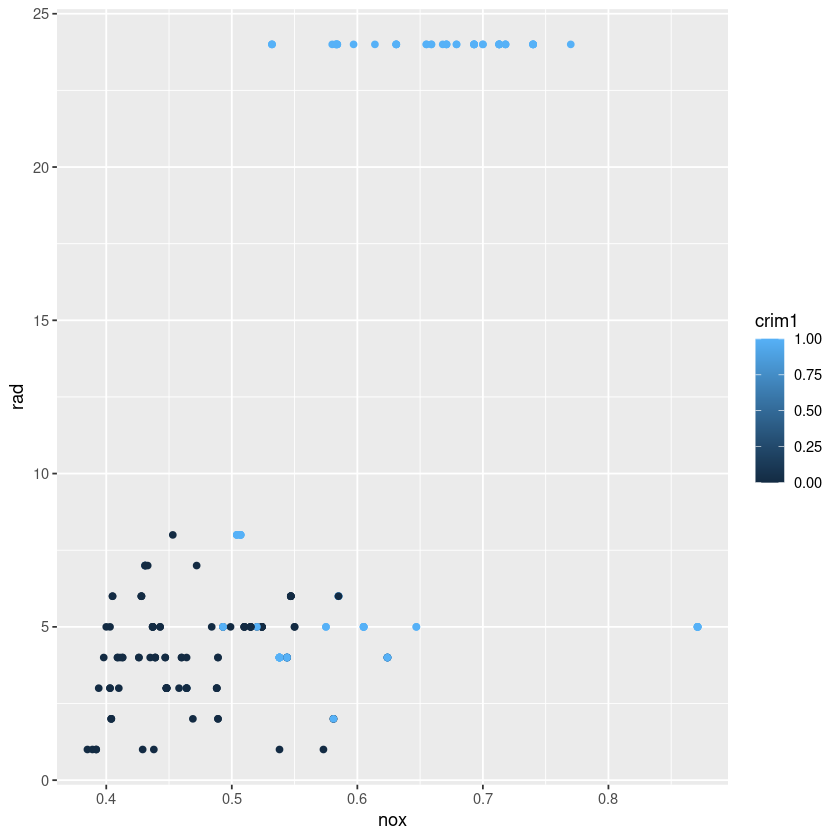

In [45]:
ggplot(data=test_bstn, mapping=aes(x=nox, y=rad))+geom_point(aes(col=crim1))

In [46]:
#### ROC curve & AUC
lda.pred <- predict(lda.fit2)
pred_ROCR <- prediction(lda.pred$posterior[,2], test_bstn$crim1)  
roc_ROCR <- performance(pred_ROCR, measure = "tpr", x.measure = "fpr")
pred_ROCR_logsitc <- prediction(predict(glm.fits1, type='response'), test_bstn$crim1)
roc_ROCR_logsitc <- performance(pred_ROCR_logsitc, measure = "tpr", x.measure = "fpr")

[1] 0.9464182

[1] 0.9510775

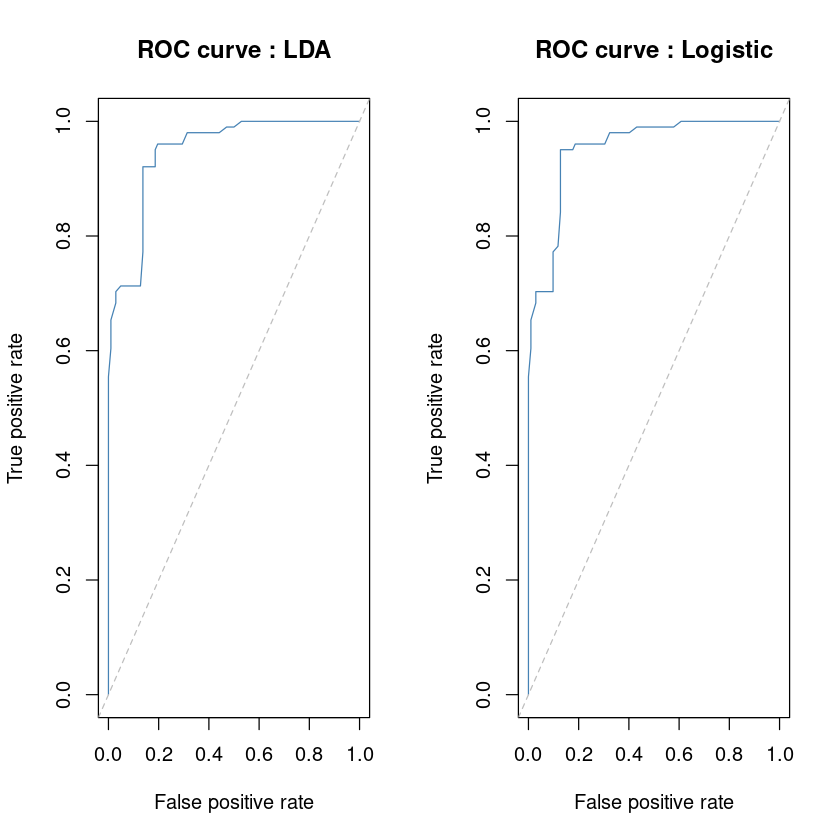

In [47]:
#그림
par(mfrow=c(1,2))
plot(roc_ROCR, main = "ROC curve : LDA", col='steelblue')
abline(a = 0, b = 1, lty=2, col='grey')
plot(roc_ROCR_logsitc, main = "ROC curve : Logistic", col='steelblue')
abline(a = 0, b = 1, lty=2, col='grey')
##### AUC
auc_ROCR <- performance(pred_ROCR, measure = "auc")
auc_ROCR@y.values[[1]]
auc_ROCR_logsitc <- performance(pred_ROCR_logsitc, measure = "auc")
auc_ROCR_logsitc@y.values[[1]]

Setting levels: control = 0, case = 1

Setting direction: controls < cases



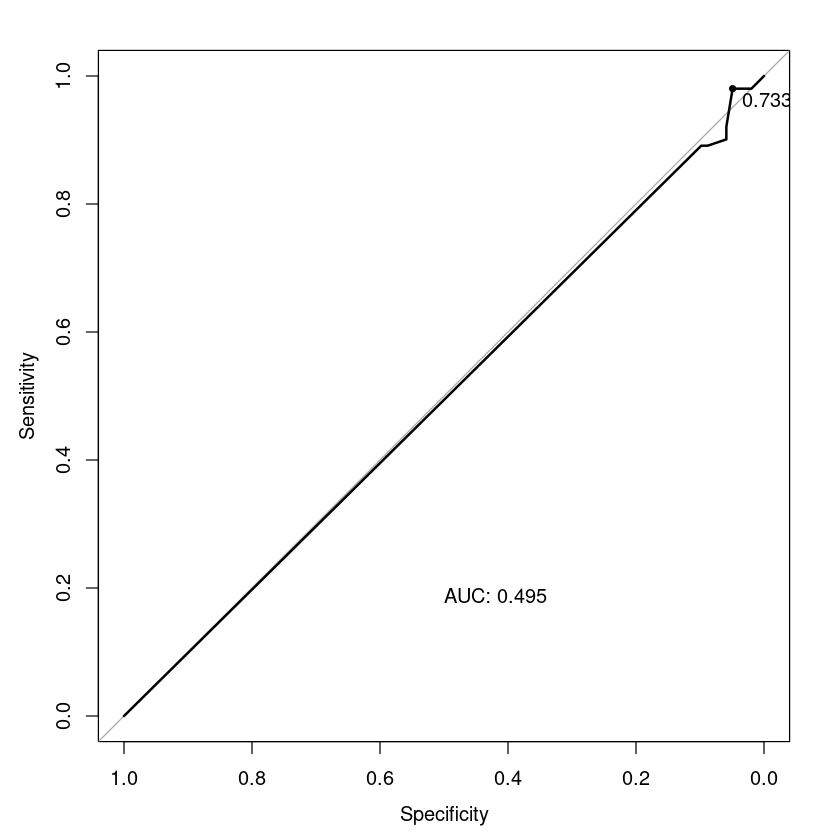

In [65]:
library(mlbench)

#install.packages("pROC")

library(pROC)

mod <- class::knn(train_bstn_x, test_bstn_x, 
                 cl=train_bstn_y, k=3, prob = T)
plot(roc(test_bstn_y, attributes(mod)$prob),
     print.thres = T,
     print.auc = T,
     print.auc.y = 0.2)